# Use Case 8: Outliers

When looking at data, we often want to identify outliers, extremely high or low data points. In this use case we will show you how to use the Deva package to find these in the CPTAC data. For more detailed information about the Deva package see [this](https://www.biorxiv.org/content/10.1101/825067v2) manuscript.

In the CPTAC breast cancer study ([here](https://www.nature.com/articles/nature18003)) it was shown that tumors classified as HER-2 enriched are frequently outliers for high abundance of ERBB2 phosphorylation, protein and mRNA (see [figure 4](https://www.nature.com/articles/nature18003/figures/4) of the manuscript). In this use case we will show that same phenomena in an independent cohort of breast cancer tumors, whose data are included in the cptac package.

## Step 1: Importing packages and setting up your notebook

Before we begin performing the analysis, we must import the packages we will be using. In this first code block, we import the standard set of data science packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In this next code block we import the deva and cptac packages and grab our proteomic and clinical data.

In [2]:
import deva
import cptac
brca = cptac.Brca()
clinical = brca.get_clinical()
proteomics = brca.get_proteomics()

## Step 2: Binarize Data

The Deva package requires that annotations are a binary variable. Our cptac tumors are divided into 4 subtypes: LumA, LumB, Basal, and Her2. We will use the binarize_annotations function to create a binary table of these PAM50 tumor classifications. We will call this table 'annotations'.

In [3]:
annotations = clinical[['PAM50']].copy()
annotations = deva.binarize_annotations(annotations)
annotations.head()

,PAM50_LumA,PAM50_Basal,PAM50_LumB,PAM50_Her2,PAM50_Normal
Sample_ID,,,,,
S001,not-LumA,Basal,not-LumB,not-Her2,not-Normal
S002,not-LumA,Basal,not-LumB,not-Her2,not-Normal
S003,not-LumA,Basal,not-LumB,not-Her2,not-Normal
S004,not-LumA,Basal,not-LumB,not-Her2,not-Normal
S005,not-LumA,Basal,not-LumB,not-Her2,not-Normal


## Step 3: Perform Outlier Analysis

Now that our dataframes are correctly formatted, we will start looking for outliers.

We will start by using the run_outliers function found in the deva package. This function takes the proteomics data frame (which we transpose to fit the requirements of the function), and the annotations data frame that includes the binarized columns. We also indicate that we want to look for up regulated genes, and that we do not want to aggregate the data. The function returns two things:
1. A data object with a dataframe which states whether a sample is an outlier for a specific protein. In the code block below we named this 'outliers'
2. A data object with a dataframe with the Q Values showing if a gene shows an enrichment in outliers for a specific subset of tumors as defined in annotations. In the code block below, we named this 'qvalues'.

In [4]:
outliers, qvalues = deva.run_outliers(proteomics.transpose(),
                                      annotations,
                                      up_or_down='up',
                                      aggregate=False,
                                      frac_filter=0.3)

01/16/2020 16:46:18:WARNING:No rows tested for fisherFDR_PAM50_LumA_not-LumA
01/16/2020 16:46:18:WARNING:No rows tested for fisherFDR_PAM50_LumA_LumA
01/16/2020 16:46:20:WARNING:No rows tested for fisherFDR_PAM50_Basal_not-Basal
01/16/2020 16:46:20:WARNING:No rows tested for fisherFDR_PAM50_LumB_not-LumB
01/16/2020 16:46:21:WARNING:No rows tested for fisherFDR_PAM50_Her2_not-Her2
01/16/2020 16:46:21:WARNING:No rows tested for fisherFDR_PAM50_Normal_not-Normal


In [5]:
print(outliers.df)

                                                  S001_outliers  \
Name   Database_ID                                                
A1BG   NP_570602.2                                          0.0   
A2M    NP_000005.2                                          0.0   
A2ML1  NP_653271.2|NP_001269353.1                           1.0   
AAAS   NP_056480.1|NP_001166937.1                           1.0   
AACS   NP_076417.2|NP_001306769.1|NP_001306768.1            0.0   
...                                                         ...   
ZXDC   NP_079388.3|NP_001035743.1                           0.0   
ZYG11B NP_078922.1                                          0.0   
ZYX    NP_001010972.1                                       0.0   
ZZEF1  NP_055928.3                                          0.0   
ZZZ3   NP_056349.1|NP_001295166.1                           0.0   

                                                  S002_outliers  \
Name   Database_ID                                           

## Step 4: Inspect Results

Because these two tables that are returned are quite complex, we will now look at each of these individually.

The outliers table indicates whether each sample is an outlier for a particular gene. In this use case, we will focus on ERBB2. The first line below simplifies the index for each row by dropping the database id and leaving the gene name. We also only print off a portion of the table for brevity.

In [5]:
outliers.df.index = outliers.df.index.droplevel('Database_ID')
erbb2_outliers = outliers.df[outliers.df.index.str.match('ERBB2')]
erbb2_outliers.iloc[:, :8]

,S001_outliers,S002_outliers,S003_outliers,S004_outliers,S005_outliers,S006_outliers,S007_outliers,S008_outliers
Name,,,,,,,,
ERBB2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In the chart above you can see that most of the samples have 0, indiciating that the sample is not an outlier for ERBB2 protein abundance. Sample 8, however, has a 1, indicating that particular sample is an outlier.

The Outliers table contains boolean columns for both outlier and notOutliers. The notOutliers columns are redundant so we will remove them.

In [7]:
erbb2_outliers = erbb2_outliers.loc[:,~erbb2_outliers.columns.str.endswith('notOutliers')]

We can now complile a list of all the samples that were considered to be outliers.

In [8]:
outlier_list = erbb2_outliers.columns[erbb2_outliers.isin([1.0]).all()].tolist()
print(outlier_list)

['S008_outliers', 'S035_outliers', 'S047_outliers', 'S048_outliers', 'S051_outliers', 'S054_outliers', 'S055_outliers', 'S070_outliers', 'S071_outliers', 'S075_outliers', 'S090_outliers', 'S107_outliers', 'S118_outliers', 'S121_outliers']


## Step 5: Visualizing Outliers
To understand what this means, we will plot the proteomics data for the ERBB2 gene and label the outlier samples. Before we graph the result we will join the proteomics and clinical data, isolating the PAM50 subtype and ERBB2.

In [9]:
combined_data = brca.join_metadata_to_omics(metadata_df_name="clinical", 
                                            omics_df_name="proteomics", 
                                            metadata_cols=["PAM50"],
                                            omics_genes=['ERBB2'])
combined_data.columns = combined_data.columns.droplevel("Database_ID")

We will now create the graph.

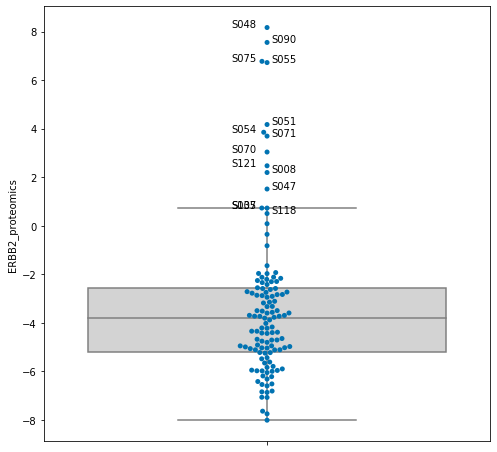

In [10]:
plt.figure(figsize=(8, 8))
sns.set_palette('colorblind')
ax = sns.boxplot(data=combined_data, showfliers=False, y='ERBB2_proteomics', color='lightgray')
left = False
# This for loop labels all the specific outlier data points.
for sample in outlier_list:
    if left:
        position = -0.08
        left = False
    else:
        position = 0.01
        left = True
    sample = sample.split("_")[0]
    ax.annotate(sample, (position, combined_data.transpose()[sample].values[1]))
ax = sns.swarmplot(data=combined_data, y='ERBB2_proteomics')

As you can see from this graph, the samples we labeled, which had a 1.0 in the outliers table were all located at the top of the graph, indicating they are very highly expressed.

## Step 6: Looking at the Qvalue table

Let's now take a look at the Qvalues table. Remember that the qvalues table indicates the probability that a gene shows an enrichment in outliers for categories defined in our annotation dataframe.

In [11]:
qvalues.df.head()

,,fisherFDR_PAM50_Basal_Basal,fisherFDR_PAM50_LumB_LumB,fisherFDR_PAM50_Her2_Her2,fisherFDR_PAM50_Normal_Normal
Name,Database_ID,,,,
A2ML1,NP_653271.2|NP_001269353.1,1.441146e-07,NaN,NaN,NaN
ABCC11,NP_149163.2|NP_660187.1|NP_150229.2,NaN,NaN,0.001545,NaN
ABCC5,NP_005679.2|NP_001306961.1|NP_001018881.1,NaN,NaN,NaN,0.093281
ACACB,NP_001084.3,NaN,NaN,NaN,0.068994
ACAD8,NP_055199.1,NaN,NaN,NaN,0.093281


This table includes all the q-values. Before really analyzing the table we will want to remove any insignificant q-values. For our purposes we will remove any q-values that are greater than 0.05.

In [12]:
for col in qvalues.df.columns:
    qvalues.df.loc[qvalues.df[col] > 0.05, col] = np.nan

We will now isolate the ERBB2 gene.

In [13]:
qvalues.df.index = qvalues.df.index.droplevel('Database_ID')
qvalues = qvalues.df[qvalues.df.index.str.match('ERBB2')]
erbb2_qvalues = qvalues.reset_index()['Name'] == 'ERBB2'
qvalues = qvalues.reset_index()[erbb2_qvalues]
qvalues.head()

,Name,fisherFDR_PAM50_Basal_Basal,fisherFDR_PAM50_LumB_LumB,fisherFDR_PAM50_Her2_Her2,fisherFDR_PAM50_Normal_Normal
0,ERBB2,NaN,NaN,0.000366,NaN


Here we see that the only PAM50 subtype that has a significant enrichment is the Her2, which is exactly what is to be expected. To visualize this pattern, we will create a graph similiar to the one above, but with each of the categories in the PAM50 category differentially colored.

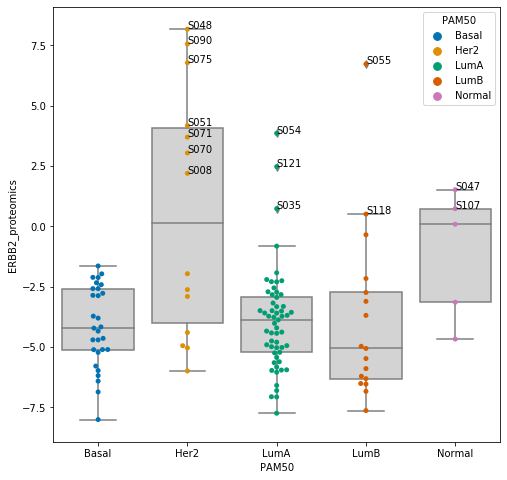

In [14]:
plt.figure(figsize=(8, 8))
sns.set_palette('colorblind')
cols = {'Basal': 0, 'Her2':1, 'LumA':2, 'LumB':3, 'Normal':4}
ax = sns.boxplot(data=combined_data, y='ERBB2_proteomics', x='PAM50', color='lightgray')
ax = sns.swarmplot(data=combined_data, y='ERBB2_proteomics',x='PAM50', hue='PAM50')
for sample in outlier_list:
    sample = sample.split("_")[0]
    ax.annotate(sample, (cols[combined_data.transpose()[sample].values[0]], combined_data.transpose()[sample].values[1]))

Looking at the distribution of the graph you can see that distribution of the Her2 category is much different than the distributions of the other catgeories. The median of the proteomic data in the Her2 category is much higher than other categories, with many more data points in the upper portion of the graph.

## Additional Applications

We have just walked through one example of how you might use the Outlier Analysis. Using this same approach, you can run the outlier analysis on a number of different clinical attributes, cohorts, and omics data. For example, you may look for outliers within the transcriptomics of the Endometrial cancer type using the clinical attribute of Histological_type. You can also look at more than one clinical attribute at a time by appending more attributes to your annotations table, or you can look for downregulated omics by chaning the 'up_or_down' variable of the run_outliers function.